In [41]:
import shap
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [42]:
data = pd.read_csv('heart_disease.csv')
data['num'] = data['num'].apply(lambda x: 0 if x == 0 else 1)
cols_to_drop = [col for col in ['id', 'dataset'] if col in data.columns]
data = data.drop(cols_to_drop, axis=1)
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('num') if 'num' in categorical_cols else None

In [49]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Split into features and target
X = data.drop(columns=['num'])
y = data['num']


In [44]:
X = data.drop('num', axis=1)
y = data['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values_pos = shap_values[1] if isinstance(shap_values, list) else shap_values

# Verify alignment
print("X_test shape:", X_test.shape)
print("SHAP shape:", shap_values_pos.shape)
assert X_test.shape[0] == shap_values_pos.shape[0], "Mismatch between X_test and SHAP rows!"


X_test shape: (184, 13)
SHAP shape: (184, 13, 2)


SHAP (positive class) shape: (184, 13)


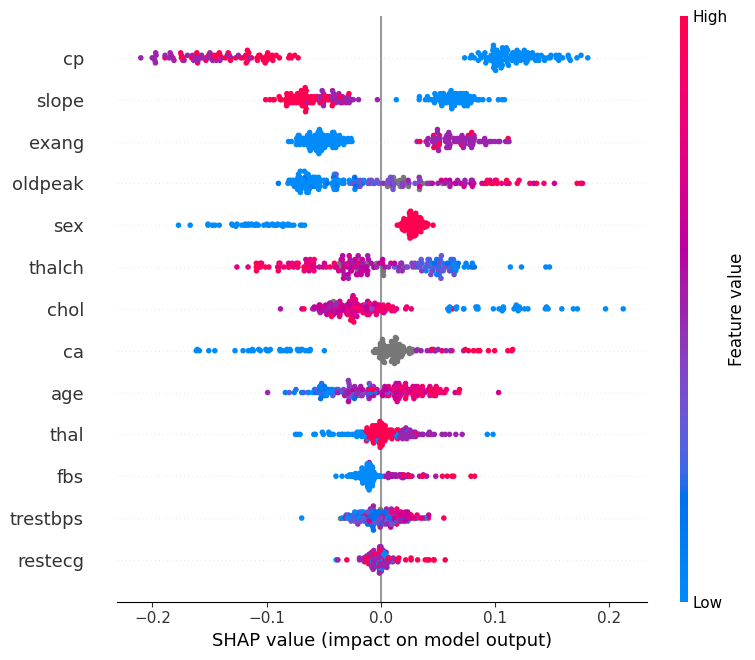

In [55]:
shap_values_pos = shap_values[:, :, 1]

print("SHAP (positive class) shape:", shap_values_pos.shape)

shap.summary_plot(shap_values_pos, X_test, plot_type="dot")

In [56]:
shap_sum = shap_values_pos.sum(axis=1)
preds = model.predict_proba(X_test)[:, 1]
fidelity = np.corrcoef(preds, shap_sum)[0, 1]
print("Fidelity:", round(fidelity, 3))


Fidelity: 1.0


In [65]:
def stability_score(explainer, sample, n_perturb=5, noise=0.01):
    shap_vals = explainer.shap_values(sample)
    
    # Handle both list and 3D array outputs
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]  # positive class
    elif shap_vals.ndim == 3:
        shap_vals = shap_vals[:, :, 1]  # take class 1 (positive)

    base = shap_vals[0].flatten()  # SHAP values for the base sample
    similarities = []
    
    for _ in range(n_perturb):
        perturbed = sample + np.random.normal(0, noise, sample.shape)
        shap_pert = explainer.shap_values(perturbed)
        
        if isinstance(shap_pert, list):
            shap_pert = shap_pert[1]
        elif shap_pert.ndim == 3:
            shap_pert = shap_pert[:, :, 1]
            
        pert_vals = shap_pert[0].flatten()
        
        # Cosine similarity
        cos_sim = np.dot(base, pert_vals) / (np.linalg.norm(base) * np.linalg.norm(pert_vals))
        similarities.append(cos_sim)
    
    return np.mean(similarities)

sample = X_test.iloc[:1].values
stability = stability_score(explainer, sample)
print("Stability (average cosine similarity):", round(stability, 3))


Stability (average cosine similarity): 1.0


In [ ]:
start_time = time.time()
_ = explainer.shap_values(X_test)
efficiency = time.time() - start_time
print("Efficiency (seconds):", round(efficiency, 3))

Efficiency (seconds): 0.805
